Fix shapedirs bug of MANO


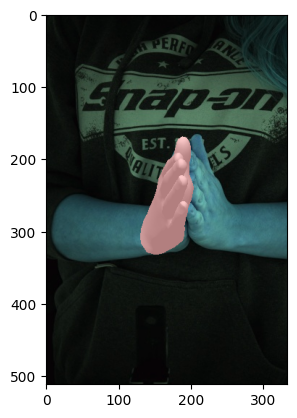

In [5]:
import os
import numpy as np
import cv2
import json
from glob import glob
import os.path as osp
os.environ["PYOPENGL_PLATFORM"] = "egl"
import smplx
import torch
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
PointLights,
DirectionalLights,
PerspectiveCameras,
Materials,
SoftPhongShader,
RasterizationSettings,
MeshRenderer,
MeshRendererWithFragments,
MeshRasterizer,
TexturesVertex)

def save_obj(v, f, file_name='output.obj'):
    obj_file = open(file_name, 'w')
    for i in range(len(v)):
        obj_file.write('v ' + str(v[i][0]) + ' ' + str(v[i][1]) + ' ' + str(v[i][2]) + '\n')
    for i in range(len(f)):
        obj_file.write('f ' + str(f[i][0]+1) + '/' + str(f[i][0]+1) + ' ' + str(f[i][1]+1) + '/' + str(f[i][1]+1) + ' ' + str(f[i][2]+1) + '/' + str(f[i][2]+1) + '\n')
    obj_file.close()

def render_mesh(mesh, face, cam_param, render_shape, hand_type):
    batch_size, vertex_num = mesh.shape[:2]
    mesh = mesh / 1000 # milimeter to meter

    textures = TexturesVertex(verts_features=torch.ones((batch_size,vertex_num,3)).float().cuda())
    mesh = torch.stack((-mesh[:,:,0], -mesh[:,:,1], mesh[:,:,2]),2) # reverse x- and y-axis following PyTorch3D axis direction
    mesh = Meshes(mesh, face, textures)

    cameras = PerspectiveCameras(focal_length=cam_param['focal'],
                                principal_point=cam_param['princpt'],
                                device='cuda',
                                in_ndc=False,
                                image_size=torch.LongTensor(render_shape).cuda().view(1,2))
    raster_settings = RasterizationSettings(image_size=render_shape, blur_radius=0.0, faces_per_pixel=1, perspective_correct=True)
    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings).cuda()
    lights = PointLights(device='cuda')
    shader = SoftPhongShader(device='cuda', cameras=cameras, lights=lights)
    if hand_type == 'right':
        color = ((1.0, 0.0, 0.0),)
    else:
        color = ((0.0, 1.0, 0.0),)
    materials = Materials(
	device='cuda',
        specular_color=color,
	shininess=0
    )

    # render
    with torch.no_grad():
        renderer = MeshRendererWithFragments(rasterizer=rasterizer, shader=shader)
        images, fragments = renderer(mesh, materials=materials)
        images = images[:,:,:,:3] * 255
        depthmaps = fragments.zbuf

    return images, depthmaps

# mano layer
smplx_path = '/home/azhuavlev/Desktop/Data/models/mano/MANO_RIGHT.pkl'
mano_layer = {'right': smplx.create(smplx_path, 'mano', use_pca=False, is_rhand=True), 'left': smplx.create(smplx_path, 'mano', use_pca=False, is_rhand=False)}

# fix MANO shapedirs of the left hand bug (https://github.com/vchoutas/smplx/issues/48)
if torch.sum(torch.abs(mano_layer['left'].shapedirs[:,0,:] - mano_layer['right'].shapedirs[:,0,:])) < 1:
    print('Fix shapedirs bug of MANO')
    mano_layer['left'].shapedirs[:,0,:] *= -1

root_path = '/home/azhuavlev/Desktop/Data/InterHand/'
img_root_path = osp.join(root_path, 'images')
annot_root_path = osp.join(root_path, 'annotations')
split = 'train'
capture_idx = '13'
seq_name = '0266_dh_pray'
cam_idx = '400030'

save_path = osp.join(split, capture_idx, seq_name, cam_idx)
os.makedirs(save_path, exist_ok=True)

with open(osp.join(annot_root_path, split, 'InterHand2.6M_' + split + '_MANO_NeuralAnnot.json')) as f:
    mano_params = json.load(f)
with open(osp.join(annot_root_path, split, 'InterHand2.6M_' + split + '_camera.json')) as f:
    cam_params = json.load(f)
with open(osp.join(annot_root_path, split, 'InterHand2.6M_' + split + '_joint_3d.json')) as f:
    joints = json.load(f)

img_path_list = glob(osp.join(img_root_path, split, 'Capture' + capture_idx, seq_name, 'cam' + cam_idx, '*.jpg'))
for img_path in img_path_list:
    frame_idx = img_path.split('/')[-1][5:-4]
    img = cv2.imread(img_path)
    img_height, img_width, _ = img.shape

    prev_render_depth = None
    for hand_type in ('right', 'left'):
        # get mesh coordinate
        try:
            mano_param = mano_params[capture_idx][frame_idx][hand_type]
            if mano_param is None:
                continue
        except KeyError:
            continue

        # get MANO 3D mesh coordinates (world coordinate)
        mano_pose = torch.FloatTensor(mano_param['pose']).view(-1,3)
        root_pose = mano_pose[0].view(1,3)
        hand_pose = mano_pose[1:,:].view(1,-1)
        shape = torch.FloatTensor(mano_param['shape']).view(1,-1)
        trans = torch.FloatTensor(mano_param['trans']).view(1,3)
        output = mano_layer[hand_type](global_orient=root_pose, hand_pose=hand_pose, betas=shape, transl=trans)
        mesh = output.vertices[0].numpy() * 1000 # meter to milimeter

        # apply camera extrinsics
        cam_param = cam_params[capture_idx]
        t, R = np.array(cam_param['campos'][str(cam_idx)], dtype=np.float32).reshape(3), np.array(cam_param['camrot'][str(cam_idx)], dtype=np.float32).reshape(3,3)
        t = -np.dot(R,t.reshape(3,1)).reshape(3) # -Rt -> t
        mesh = np.dot(R, mesh.transpose(1,0)).transpose(1,0) + t.reshape(1,3)

        # save mesh to obj files
        save_obj(mesh, mano_layer[hand_type].faces, osp.join(save_path, img_path.split('/')[-1][:-4] + '_' + hand_type + '.obj'))

        # render
        mesh = torch.from_numpy(mesh).float().cuda()[None,:,:]
        face = torch.from_numpy(mano_layer[hand_type].faces.astype(np.int32)).cuda()[None,:,:]
        focal = torch.FloatTensor(cam_param['focal'][str(cam_idx)]).cuda()[None,:]
        princpt = torch.FloatTensor(cam_param['princpt'][str(cam_idx)]).cuda()[None,:]
        with torch.no_grad():
            render_rgb, render_depth = render_mesh(mesh, face, {'focal': focal, 'princpt': princpt}, (img_height,img_width), hand_type)

        # blend
        render_rgb = render_rgb[0].cpu().numpy()
        render_depth = render_depth[0].cpu().numpy()
        valid_mask = render_depth > 0
        if prev_render_depth is None:
            render_mask = valid_mask
            render_out = render_rgb * render_mask + img * (1 - render_mask)
            prev_render_depth = render_depth
        else:
            render_mask = valid_mask * np.logical_or(render_depth < prev_render_depth, prev_render_depth<=0)
            render_out = render_rgb * render_mask + render_out * (1 - render_mask)
            prev_render_depth = render_depth * render_mask + prev_render_depth * (1 - render_mask)

    # save image
    #cv2.imwrite(osp.join(save_path, img_path.split('/')[-1]), render_out)
    import matplotlib.pyplot as plt
    plt.imshow(render_out.astype(np.uint8))
